In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import Dataset,random_split
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights,vgg19,VGG19_Weights,inception_v3,Inception_V3_Weights
from efficientnet_pytorch import EfficientNet

In [66]:
train_dataset = datasets.ImageFolder(
    "Brain-Tumor-MRI/Training",
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomVerticalFlip(p=0.7),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
        transforms.RandomRotation(30)
    ]))

test_dataset = datasets.ImageFolder(
    "Brain-Tumor-MRI/Testing",
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]))

In [67]:
"""
train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset) - train_size

"""

'\ntrain_size = int(0.8*len(train_dataset))\nval_size = len(train_dataset) - train_size\n\n'

In [68]:
#train_set , val_set = random_split(train_dataset,[train_size,val_size]) 

In [69]:
Batch_size = 32

In [70]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=Batch_size,
    shuffle=True
)

"""
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=Batch_size,
    shuffle=False
)
"""
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=Batch_size,
    shuffle=False
)

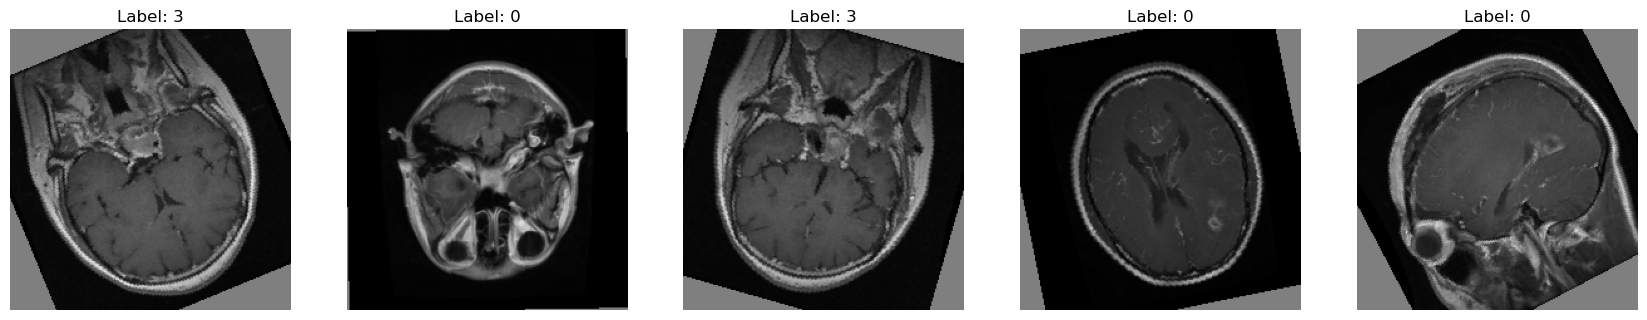

In [71]:
train_iter = iter(train_loader)
images, labels = next(train_iter)
n = 5
fig, axes = plt.subplots(1, n, figsize=(21, 10))

for i in range(n):
    image = images[i]
    label = labels[i]

    # Unnormalize the image if normalization [0.5],[0.5] was applied
    image = image * 0.5 + 0.5

    # Tensor to NumPy array 
    image = image.numpy().transpose((1, 2, 0))

    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis("off");


In [72]:
len(train_dataset)

2870

In [73]:
len(test_dataset)

394

In [74]:
class MRI_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.drop1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.drop2 = nn.Dropout(0.3)
        """
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        """   
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64*54*54,64)
        self.drop3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64,256)
        #self.drop4 = nn.Dropout(0.2)
        self.out = nn.Linear(256,4)
        
     
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        """
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        """  
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = F.relu(self.fc2(x))
        #x = self.drop4(x)
        x = self.out(x)
        
        return x

In [75]:
model = MRI_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)

In [80]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: Brain-Tumor-MRI/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomVerticalFlip(p=0.7)
               RandomHorizontalFlip(p=0.7)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )

In [ ]:
n_epoch = 60

for epoch in range(1, n_epoch + 1):
    
    model.train() 
    total_train_correct = 0
    total_train_samples = len(train_dataset)
    total_val_correct = 0
    total_val_samples = len(val_set)


    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model.forward(image)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        _, predicted_labels = torch.max(y_pred, 1)
        total_train_correct += (predicted_labels == label).sum().item()

        if (i + 1) % 10 == 0:
            print(f"Epoch={epoch} : Batch={i + 1} : Training Loss={loss.item():.7f}")
            
  
    #Validation Step: 
     
    model.eval() 
    with torch.no_grad():
        for i, (val_img, val_label) in enumerate(val_loader):
            y_pred = model.forward(val_img)
            loss = criterion(y_pred, val_label)
            _, predicted_labels = torch.max(y_pred, 1)
            total_val_correct += (predicted_labels == val_label).sum().item()
    
    train_accuracy = total_train_correct / total_train_samples            
    val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch={epoch} : Train Accuracy={train_accuracy * 100:.2f}% : Test Accuracy={test_accuracy * 100:.2f}%")

Epoch=1 : Batch=10 : Training Loss=1.4102607
Epoch=1 : Batch=20 : Training Loss=1.3958397
Epoch=1 : Batch=30 : Training Loss=1.2641984
Epoch=1 : Batch=40 : Training Loss=1.1000479
Epoch=1 : Batch=50 : Training Loss=0.9865431
Epoch=1 : Batch=60 : Training Loss=0.9148880
Epoch=1 : Batch=70 : Training Loss=0.8796989
Epoch=1 : Batch=80 : Training Loss=0.9091541
Epoch=1 : Batch=90 : Training Loss=0.9764855
Epoch=1 : Test Loss=1.5283402
Epoch=1 : Test Loss=0.9150543
Epoch=1 : Train Accuracy=46.59% : Test Accuracy=28.93%
Epoch=2 : Batch=10 : Training Loss=0.7526771
Epoch=2 : Batch=20 : Training Loss=0.7769019
Epoch=2 : Batch=30 : Training Loss=0.8259786
Epoch=2 : Batch=40 : Training Loss=0.7951512
Epoch=2 : Batch=50 : Training Loss=0.9377527
Epoch=2 : Batch=60 : Training Loss=0.8156620
Epoch=2 : Batch=70 : Training Loss=0.7101896
Epoch=2 : Batch=80 : Training Loss=1.0534430
Epoch=2 : Batch=90 : Training Loss=0.7861483
Epoch=2 : Test Loss=0.8509530
Epoch=2 : Test Loss=0.6839248
Epoch=2 : Train

Epoch=16 : Batch=80 : Training Loss=0.5029183
Epoch=16 : Batch=90 : Training Loss=0.3359162
Epoch=16 : Test Loss=0.3595396
Epoch=16 : Test Loss=0.2402372
Epoch=16 : Train Accuracy=81.78% : Test Accuracy=62.18%
Epoch=17 : Batch=10 : Training Loss=0.3438534
Epoch=17 : Batch=20 : Training Loss=0.4926213
Epoch=17 : Batch=30 : Training Loss=0.4207273
Epoch=17 : Batch=40 : Training Loss=0.3553991
Epoch=17 : Batch=50 : Training Loss=0.2428286
Epoch=17 : Batch=60 : Training Loss=0.2694366
Epoch=17 : Batch=70 : Training Loss=0.3307247
Epoch=17 : Batch=80 : Training Loss=0.3912015
Epoch=17 : Batch=90 : Training Loss=0.4216989
Epoch=17 : Test Loss=0.8231193
Epoch=17 : Test Loss=0.0447005
Epoch=17 : Train Accuracy=81.60% : Test Accuracy=54.31%
Epoch=18 : Batch=10 : Training Loss=0.3743955
Epoch=18 : Batch=20 : Training Loss=0.3885199
Epoch=18 : Batch=30 : Training Loss=0.5776802
Epoch=18 : Batch=40 : Training Loss=0.4614922
Epoch=18 : Batch=50 : Training Loss=0.3424105
Epoch=18 : Batch=60 : Traini

Epoch=32 : Batch=20 : Training Loss=0.4663699
Epoch=32 : Batch=30 : Training Loss=0.3805422
Epoch=32 : Batch=40 : Training Loss=0.4018442
Epoch=32 : Batch=50 : Training Loss=0.4399114
Epoch=32 : Batch=60 : Training Loss=0.2935769
Epoch=32 : Batch=70 : Training Loss=0.3389964
Epoch=32 : Batch=80 : Training Loss=0.2017161
Epoch=32 : Batch=90 : Training Loss=0.6538570
Epoch=32 : Test Loss=0.2327451
Epoch=32 : Test Loss=0.0203225
Epoch=32 : Train Accuracy=87.56% : Test Accuracy=64.72%
Epoch=33 : Batch=10 : Training Loss=0.7650619
Epoch=33 : Batch=20 : Training Loss=0.3570595
Epoch=33 : Batch=30 : Training Loss=0.3307060
Epoch=33 : Batch=40 : Training Loss=0.3520206
Epoch=33 : Batch=50 : Training Loss=0.0895789
Epoch=33 : Batch=60 : Training Loss=0.2012674
Epoch=33 : Batch=70 : Training Loss=0.1441860
Epoch=33 : Batch=80 : Training Loss=0.2417434
Epoch=33 : Batch=90 : Training Loss=0.6429237
Epoch=33 : Test Loss=0.1804561
Epoch=33 : Test Loss=0.0723135
Epoch=33 : Train Accuracy=87.32% : Tes

In [44]:
correct_predictions = 0
total_samples = len(test_dataset)
model.eval()
with torch.no_grad():
    for b, (image, label) in enumerate(test_loader):
        y_pred = model.forward(image)
        predicted_labels = torch.argmax(y_pred, dim=1)
        correct_predictions += (predicted_labels == label).sum().item()

accuracy = correct_predictions / total_samples
print(f"Accuracy on test set = {accuracy * 100:.2f}% : test corr = {correct_predictions}")

Accuracy on test set = 64.21% : test corr = 253


In [45]:
test_dataset.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [52]:
img = Image.open("Brain-Tumor-MRI/Testing/no_tumor/image(97).jpg")

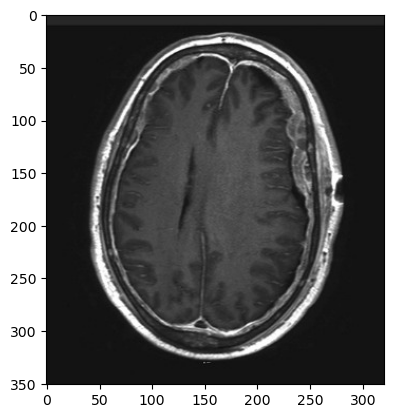

In [53]:
plt.imshow(img);

In [54]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [55]:
img_tensor = transform(img).unsqueeze(0)

In [56]:
model.eval()
with torch.no_grad():
    pred = model.forward(img_tensor)
    pred = torch.argmax(pred,1)

In [57]:
pred

tensor([2])